# japanese-mistral-300m-recipe quick start

本資料は、japanese-mistral-300m-recipeを用いた学習・ファインチューニングを簡単に試すためのスクリプトです。  
内容は以下の通りです。japanese-mistral-300m-recipeの実装内容の一部を抜き出した物となっています。

1. 環境構築
2. データセット構築（wikipediaデータのみ使用）
3. トークナイザー学習
4. 事前学習&評価
5. 推論
6. ファインチューニング
7. 推論
8. SHAPを使用した推論結果への寄与度分析


## 0. 使用環境

- システムRAM:12.7GB
- GPU:T4 GPU
- ディスク: 166.8GB

ランタイムのタイプは画面上部の「ランタイム>ランタイムのタイプを変更」より、T4 GPUとしてください。  
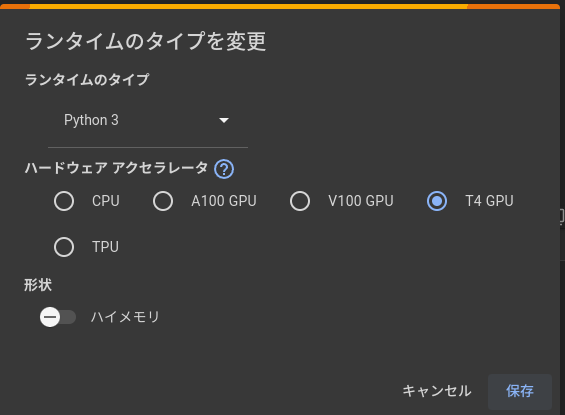


## 1. 環境構築

cuda関連の設定を行います。

In [1]:
# cudaバージョンを確認する
!nvcc --version

# refer:https://github.com/pytorch/pytorch/issues/107960
# torch.compile時のlibcuda.so not foundエラーの回避策
!ldconfig /usr/lib64-nvidia

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link



必要なpythonライブラリをインストールします。  

以下の依存関係エラーが出るかと思いますが、スルーで大丈夫です。

>WARNING: The following packages were previously imported in this runtime:
  [PIL,certifi,google,numpy,psutil]
You must restart the runtime in order to use newly installed versions.

In [2]:
%%time
!nvcc --version

!git clone https://github.com/ce-lery/japanese-mistral-300m-recipe.git
%cd japanese-mistral-300m-recipe
#!git checkout v0.1.0 # TODO：動作確認
# 以下torchのインストール部分が、そのうち動かなくなるかも（ColabのコンテナのCUDAバージョン変更に伴い）
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -r requirements.txt
!pip install flash-attn==2.3.4 --no-build-isolation

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Cloning into 'japanese-mistral-300m-recipe'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 151 (delta 64), reused 132 (delta 46), pack-reused 0
Receiving objects: 100% (151/151), 38.48 KiB | 12.83 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/japanese-mistral-300m-recipe
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.3.4-cp310-cp310-linux_x86_64.whl size=57449248 sha256=4ceff7f9ad6a6747975b568f3193b2416f598808b5e860fb09555dbfa32b42cf
  Stored in directory: /root/.cache/pip/wheels/32/19/1b/bf8147431c43f8b8d2b2e5d66be1ebf586f2fca96d72203f53
Successfully built flash-attn
CPU times: user 959 ms, sys: 177 ms, total: 1.14 s
Wall time: 2min 11s


（T4のみ）flash_attention2が対応していないため、無効化します。


In [3]:
%%bash
# "RuntimeError: FlashAttention only supports Ampere GPUs or newer."を回避するためにuse_flash_attention_2を無効化する
sed -ie 's/use_flash_attention_2=True/use_flash_attention_2=False/g' pretrain/train/run_clm.py

## 2. データセット構築
wikipediaデータセットのみダウンロードし、学習に使用します。  
ダウンロード高速化のため、[こちら](TODO)のデータセットのうち、日本語（ja）のみダウンロードします。  

In [4]:
%%time
!GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/datasets/graelo/wikipedia.git
%cd wikipedia/data/20230601/ja/
!git lfs pull --include "train-*-of-0015.parquet"
%cd ../../../../

Cloning into 'wikipedia'...
remote: Enumerating objects: 2001, done.
remote: Total 2001 (delta 0), reused 0 (delta 0), pack-reused 2001
Receiving objects: 100% (2001/2001), 255.26 KiB | 15.95 MiB/s, done.
Resolving deltas: 100% (616/616), done.
/content/japanese-mistral-300m-recipe/wikipedia/data/20230601/ja
/content/japanese-mistral-300m-recipe
CPU times: user 1.56 s, sys: 226 ms, total: 1.79 s
Wall time: 2min 47s


  事前学習に使用するため、また、sentencepieceトークナイザー学習のため、trainデータセット全てを使用した.txtデータを作成します。

In [5]:
%%time
import pandas as pd
from datasets import load_dataset
import csv
import pandas as pd

# create dataset for training tokenizer
dataset = load_dataset("wikipedia/data/20230601/ja/", data_files= "train-*-of-0015.parquet",split="train")
# datasetのtext列をwiki.txtに書き出す
dataset.to_csv("wiki.txt", columns=["text"], sep="\t", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar="\\")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/1374 [00:00<?, ?ba/s]

CPU times: user 1min 53s, sys: 26.4 s, total: 2min 19s
Wall time: 3min 19s


6802686716

ダウンロードしたwikipediaデータセットのtrain/test分割は、run_clm.py内で実施（後述）するため、ここでは割愛します。

最後に、不要なファイルを削除します。
Google Colab Proユーザーの場合はこの処理は不要です。コメントアウトしてください。

In [ ]:
%%bash 
rm -r wikipedia/
rm -r spm_tokenizer_neologdn_bytefallback_nofast/model.safetensors
LINES=`wc -l wiki.txt | awk '{print $1}'`
TRAIN_DATA_LINES=$(($LINES*10/100))
head -n $TRAIN_DATA_LINES wiki.txt > wiki2.txt
rm -r wiki.txt
mv wiki2.txt wiki.txt

## 3. トークナイザー学習

トークナイザーの学習には13GB以上のハイメモリ設定が必要なため、本スクリプトでは学習はせず、こちらの学習済のトークナイザーを使用します。


In [6]:
# todo 学習済トークナイザーをダウンロード
!git clone https://huggingface.co/ce-lery/japanese-mistral-300m-base.git
# spm-wiki-cc100-for-spm-bytefallbackという名称で保存
!mv japanese-mistral-300m-base spm_tokenizer_neologdn_bytefallback_nofast

Cloning into 'japanese-mistral-300m-base'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 3), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (30/30), 947.75 KiB | 2.95 MiB/s, done.
Filtering content: 100% (11/11), 1.32 GiB | 15.71 MiB/s, done.


Google colabo Pro以上の有料版を使用可能な場合は、ハイメモリ設定を有効にし、以下のトークナイザー学習を試してみてください。

In [7]:
"""
%%time

import sentencepiece as spm
from transformers import LlamaTokenizer
from tokenizers.implementations import SentencePieceUnigramTokenizer

MODEL_PREFIX = "spm-wiki-cc100-for-spm-bytefallback"
OUTPUT_MODEL_DIR = "spm_tokenizer_neologdn_bytefallback_nofast"

spm.SentencePieceTrainer.train(
    input="wiki.txt",  # コーパスファイル
    model_type="unigram",  # デフォルト
    model_prefix=MODEL_PREFIX,  # 出力されるモデルのファイル名に使われる
    add_dummy_prefix=False,# rinna-3.6bに習って、文章の先頭にスペースが追加されないように
    byte_fallback=True,# rinna-3.6bに習って、未知語をutf-8バイトに分解するために
    vocab_size=50000,  # vocab number
    character_coverage=0.9995,
    unk_piece="[UNK]",
    pad_piece="[PAD]",
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,
    input_sentence_size=12000000 # refer:https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/part7.html
)

sp = spm.SentencePieceProcessor()
sp.Load(MODEL_PREFIX+".model")

# encode: text => is
print(sp.encode_as_pieces("これは、テストです。"))
print(sp.encode_as_ids("これは、テストです。"))

# decode: id => text
print(sp.decode_pieces(['▁', 'これは', '、', 'テスト', 'です', '。']))
print(sp.decode_ids([723, 261, 3079, 2356, 264]))
"""

'\n%%time\n\nimport sentencepiece as spm\nfrom transformers import LlamaTokenizer\nfrom tokenizers.implementations import SentencePieceUnigramTokenizer\n\nMODEL_PREFIX = "spm-wiki-cc100-for-spm-bytefallback"\nOUTPUT_MODEL_DIR = "spm_tokenizer_neologdn_bytefallback_nofast"\n\nspm.SentencePieceTrainer.train(\n    input="wiki.txt",  # コーパスファイル\n    model_type="unigram",  # デフォルト\n    model_prefix=MODEL_PREFIX,  # 出力されるモデルのファイル名に使われる\n    add_dummy_prefix=False,# rinna-3.6bに習って、文章の先頭にスペースが追加されないように\n    byte_fallback=True,# rinna-3.6bに習って、未知語をutf-8バイトに分解するために\n    vocab_size=50000,  # vocab number\n    character_coverage=0.9995,\n    unk_piece="[UNK]",\n    pad_piece="[PAD]",\n    pad_id=0,\n    unk_id=1,\n    bos_id=2,\n    eos_id=3,\n    input_sentence_size=12000000 # refer:https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/part7.html\n)\n\nsp = spm.SentencePieceProcessor()\nsp.Load(MODEL_PREFIX+".model")\n\n# encode: text => is\nprint(sp.encode_as_pieces("これは、テストです。"

SentencepieceTokenizerをTokenizersライブラリのT5Tokenizer形式に変換します。

In [8]:
"""
%%time
%cd pretrain/tokenizer

# Transformer API
tokenizer = T5Tokenizer(
    # tokenizer_object=spm_tokenizer._tokenizer,
    vocab_file="../../"+MODEL_PREFIX+".model",
    unk_token = '[UNK]',
    bos_token = '<s>',
    eos_token = '</s>',
    pad_token = '[PAD]',
    extra_ids=0,
    model_max_length=50000,
)
tokenizer.save_pretrained("../../"+OUTPUT_MODEL_DIR)

%cd ../../
"""

'\n%%time\n%cd pretrain/tokenizer\n\n# Transformer API\ntokenizer = T5Tokenizer(\n    # tokenizer_object=spm_tokenizer._tokenizer,\n    vocab_file="../../"+MODEL_PREFIX+".model",\n    unk_token = \'[UNK]\',\n    bos_token = \'<s>\',\n    eos_token = \'</s>\',\n    pad_token = \'[PAD]\',\n    extra_ids=0,\n    model_max_length=50000,\n)\ntokenizer.save_pretrained("../../"+OUTPUT_MODEL_DIR)\n\n%cd ../../\n'

## 4. 事前学習&評価

run_clm.pyに渡す設定パラメータファイル（hf_config_quick_start.json）を作成します。  
run_clm.pyの場合、validation_split_percentage引数に対して「validationデータセットとして使用したいデータサイズ(%)」を指定することで、その%でtrain-test分割を実施します。  

T4の場合、全てのwikipediaデータを使用して1回学習する（=1epoch）のに100時間かかるため、0.02epochで2時間程度で終わるように学習時間を設定しています。1epoch学習したい場合は「"max_steps":100 ,」の行を「"num_train_epochs":1,」に書き換えてください。

なお、5epoch程度学習させれば、wikipediaデータセットのみであってもそこそこ綺麗な日本語を生成するようになります。

In [9]:
%%bash

# model_typeとconfig_nameがgpt2-mediumになっているが、内部で"mistral"に上書きされるため無視でいい
# 1epoch=5657stepsなので、100stepで0.02epochぐらい. T4の場合、1epochで100hourぐらいかかるので、100stepに
cat << EOS > hf_config_quick_start.json
{
    "model_type": "gpt2",
    "config_name":"gpt2-medium" ,
    "tokenizer_name":"../spm_tokenizer_neologdn_bytefallback_nofast" ,
    "train_file":"../wiki.txt",
    "validation_split_percentage":5,
    "output_dir":"checkpoints-mistral-300M-FA2",
    "do_train":true,
    "do_eval":true,
    "prediction_loss_only":true,
    "remove_unused_columns":false ,
    "learning_rate":6.0e-4 ,
    "weight_decay":0.1 ,
    "adam_beta2":0.95 ,
    "max_steps":100 ,
    "logging_dir":"checkpoints-mistral-300M-FA2/logs",
    "logging_strategy": "steps" ,
    "logging_steps":10 ,
    "evaluation_strategy":"steps" ,
    "save_strategy": "steps" ,
    "eval_steps":100 ,
    "save_steps":100 ,
    "load_best_model_at_end":true ,
    "save_total_limit":2 ,
    "warmup_steps":1000 ,
    "lr_scheduler_type":"cosine" ,
    "per_device_train_batch_size":1 ,
    "per_device_eval_batch_size":1,
    "block_size":1024 ,
    "adam_epsilon":1.0e-4 ,
    "fp16":true ,
    "gradient_accumulation_steps":256,
    "push_to_hub":false,
    "dataloader_num_workers": 8,
    "optim":"adamw_bnb_8bit" ,
    "torch_compile":true
}
EOS

deppespeed ZERO3を使用した学習を実施します。学習パラメータの一部をRAMにオフロードすることでVRAM容量を削減でき、CUDA OUT OF MEMORYを回避した学習が可能となります。

ただし、今回の300M程度のモデルサイズの場合、ZeRO0やZeRO1でもバッチサイズ1で学習が回るので、ZeRO2やZeRO3を使用するメリットはないです。

In [10]:
%%time
%cd pretrain/

# 前の学習でできた空の学習済モデルフォルダを削除
!rm -r checkpoints-mistral-300M-FA2
!deepspeed --no_local_rank train/run_clm.py ../hf_config_quick_start.json --deepspeed --deepspeed_config train/ds_config_zero3.json

%cd ../

ストリーミング出力は最後の 5000 行に切り捨てられました。
 93% 70615/75529 [2:38:00<10:46,  7.60it/s]
 93% 70616/75529 [2:38:01<10:46,  7.60it/s]
 93% 70617/75529 [2:38:01<10:48,  7.58it/s]
 93% 70618/75529 [2:38:01<10:48,  7.57it/s]
 93% 70619/75529 [2:38:01<10:54,  7.50it/s]
 94% 70620/75529 [2:38:01<10:53,  7.51it/s]
 94% 70621/75529 [2:38:01<10:55,  7.49it/s]
 94% 70622/75529 [2:38:01<10:46,  7.59it/s]
 94% 70623/75529 [2:38:02<10:46,  7.58it/s]
 94% 70624/75529 [2:38:02<10:47,  7.58it/s]
 94% 70625/75529 [2:38:02<10:48,  7.56it/s]
 94% 70626/75529 [2:38:02<10:47,  7.57it/s]
 94% 70627/75529 [2:38:02<10:46,  7.58it/s]
 94% 70628/75529 [2:38:02<10:53,  7.50it/s]
 94% 70629/75529 [2:38:02<10:45,  7.60it/s]
 94% 70630/75529 [2:38:02<10:57,  7.45it/s]
 94% 70631/75529 [2:38:03<10:42,  7.63it/s]
 94% 70632/75529 [2:38:03<10:44,  7.60it/s]
 94% 70633/75529 [2:38:03<10:46,  7.58it/s]
 94% 70634/75529 [2:38:03<10:54,  7.48it/s]
 94% 70635/75529 [2:38:03<10:45,  7.58it/s]
 94% 70636/75529 [2:38:03<10:46,  7.57it/s]



deepspeedを使用しない場合は、以下のコマンドで学習をすることが可能です。


In [11]:
"""
%%time
%cd pretrain/
!rm -r checkpoints-mistral-300M-FA2
!python train/run_clm.py ../hf_config_quick_start.json
%cd ../
"""

'\n%%time\n%cd pretrain/\n!rm -r checkpoints-mistral-300M-FA2\n!python train/run_clm.py ../hf_config_quick_start.json\n%cd ../\n'

## 5. 推論

事前学習で生成されたデータセットを用いて、推論を実施します。  

In [12]:
%%time
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
import torch

MODEL_NAME = "./pretrain/checkpoints-mistral-300M-FA2"
torch.set_float32_matmul_precision('high')

DEVICE = "cuda"
if torch.cuda.is_available():
    print("cuda")
    DEVICE = "cuda"
else:
    print("cpu")
    DEVICE = "cpu"
# DEVICE = "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,use_fast=False)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
).to(DEVICE)

# streamer = TextStreamer(tokenizer)

prompt = "大規模言語モデルとは、"

inputs = tokenizer(prompt, add_special_tokens=False,return_tensors="pt").to(model.device)
with torch.no_grad():

    outputs = model.generate(
        inputs["input_ids"],
        max_new_tokens=256,
        do_sample=True,
        early_stopping=False,
        top_p=0.95,
        top_k=50,
        temperature=0.9,
        # streamer=streamer,
        no_repeat_ngram_size=2,
        num_beams=3
    )

print(outputs.tolist()[0])
outputs_txt = tokenizer.decode(outputs[0])
print(outputs_txt)

cuda


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


[9114, 2342, 1073, 396, 260, 316, 316, 42974, 316, 10951, 316, 261, 10951, 42974, 42974, 264, 261, 260, 260, 261, 261, 272, 260, 262, 261, 262, 260, 275, 261, 273, 260, 264, 260, 273, 261, 279, 260, 279, 261, 264, 263, 260, 263, 261, 263, 262, 264, 262, 272, 261, 275, 260, 266, 260, 268, 260, 284, 260, 282, 260, 265, 260, 315, 260, 272, 275, 262, 279, 262, 263, 279, 275, 272, 262, 262, 266, 261, 1722, 316, 263, 264, 264, 275, 316, 260, 267, 260, 269, 261, 268, 261, 265, 262, 273, 263, 272, 272, 279, 263, 266, 262, 316, 262, 318, 262, 265, 261, 266, 263, 263, 275, 273, 266, 275, 263, 270, 262, 275, 264, 273, 262, 269, 260, 295, 260, 270, 261, 267, 261, 270, 260, 318, 260, 292, 261, 284, 261, 316, 1722, 261, 282, 261, 309, 260, 305, 261, 305, 260, 10951, 263, 267, 272, 263, 265, 264, 268, 263, 273, 279, 279, 264, 266, 270, 264, 272, 266, 264, 279, 265, 279, 273, 275, 279, 284, 316, 269, 262, 270, 265, 275, 266, 273, 264, 267, 262, 284, 262, 267, 265, 263, 268, 262, 282, 266, 266, 279, 27

## 6. ファインチューニング&評価

事前学習済モデルをベースに、[kunishou/databricks-dolly-15k-ja](https://huggingface.co/datasets/kunishou/databricks-dolly-15k-ja)を用いてinstructionチューニングを実施します。  

データセットをダウンロードします。  

In [13]:
%%time
%cd fine-tuning/dataset
!GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/datasets/kunishou/databricks-dolly-15k-ja.git
%cd databricks-dolly-15k-ja
!git lfs pull --include "databricks-dolly-15k-ja.json"
%cd ../../../

/content/japanese-mistral-300m-recipe/fine-tuning/dataset
Cloning into 'databricks-dolly-15k-ja'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 58 (delta 1), reused 1 (delta 1), pack-reused 53
Unpacking objects: 100% (58/58), 6.67 KiB | 455.00 KiB/s, done.
/content/japanese-mistral-300m-recipe/fine-tuning/dataset/databricks-dolly-15k-ja
/content/japanese-mistral-300m-recipe
CPU times: user 56.6 ms, sys: 6.99 ms, total: 63.6 ms
Wall time: 4.94 s


次に、データセットを以下のようなalpaca形式に変換します。

```bash
<s>
以下は、タスクを説明する指示と、文脈のある入力の組み合わせです。要求を適切に満たす応答を書きなさい。
[SEP]
指示:
あなたは何でも正確に答えられるAIです。
[SEP]
入力:
User:日本で一番高い山は?
[SEP]
応答:
富士山
</s>
```

In [14]:
%%time
!python fine-tuning/dataset/alpaca_preprocess.py

{'index': '0', 'instruction': 'ヴァージン・オーストラリア航空はいつから運航を開始したのですか？', 'input': 'ヴァージン・オーストラリア航空（Virgin Australia Airlines Pty Ltd）はオーストラリアを拠点とするヴァージン・ブランドを冠する最大の船団規模を持つ航空会社です。2000年8月31日に、ヴァージン・ブルー空港として、2機の航空機、1つの空路を運行してサービスを開始しました。2001年9月のアンセット・オーストラリア空港の崩壊後、オーストラリアの国内市場で急速に地位を確立しました。その後はブリスベン、メルボルン、シドニーをハブとして、オーストラリア国内の32都市に直接乗り入れるまでに成長しました。', 'output': 'ヴァージン・オーストラリア航空は、2000年8月31日にヴァージン・ブルー航空として、2機の航空機で単一路線の運航を開始しました。', 'category': 'closed_qa'}
100% 15015/15015 [00:00<00:00, 193524.96it/s]
CPU times: user 30.3 ms, sys: 2.85 ms, total: 33.1 ms
Wall time: 3.42 s


ファインチューニング用のconfigファイルを作成します。

In [15]:
%%bash

cat << EOS > hf_config_ft_quick_start.json
{
    "model_name_or_path":"./pretrain/checkpoints-mistral-300M-FA2",
    "train_file":"./fine-tuning/dataset/databricks-dolly-15k-ja.txt",
    "trust_remote_code": true,
    "validation_split_percentage":10,
    "output_dir":"checkpoints-finetuning",
    "do_train":true,
    "do_eval":true,
    "prediction_loss_only":true,
    "remove_unused_columns":false ,
    "learning_rate":5.0e-6 ,
    "weight_decay":0.1 ,
    "adam_beta2":0.95 ,
    "num_train_epochs":4,
    "logging_dir":"checkpoints-finetuning/logs",
    "logging_strategy": "steps" ,
    "logging_steps":4 ,
    "evaluation_strategy":"steps" ,
    "save_strategy": "steps" ,
    "eval_steps":4 ,
    "save_steps":4 ,
    "load_best_model_at_end":true ,
    "save_total_limit":2 ,
    "warmup_steps":1000 ,
    "lr_scheduler_type":"cosine" ,
    "per_device_train_batch_size":1 ,
    "per_device_eval_batch_size":1,
    "block_size":1024 ,
    "adam_epsilon":1.0e-4 ,
    "fp16":true ,
    "gradient_accumulation_steps":256 ,
    "push_to_hub":false,
    "dataloader_num_workers": 8,
    "optim":"adamw_bnb_8bit" ,
    "torch_compile":true
}
EOS

ファインチューニングを実施します。

In [16]:
%%time
%rm -r checkpoints-finetuning/
!deepspeed --no_local_rank pretrain/train/run_clm.py hf_config_ft_quick_start.json --deepspeed --deepspeed_config pretrain/train/ds_config_zero3.json

rm: cannot remove 'checkpoints-finetuning/': No such file or directory
[2023-12-12 00:43:23,730] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2023-12-12 00:43:27,575] [WARNING] [runner.py:203:fetch_hostfile] Unable to find hostfile, will proceed with training with local resources only.
[2023-12-12 00:43:27,576] [INFO] [runner.py:570:main] cmd = /usr/bin/python3 -u -m deepspeed.launcher.launch --world_info=eyJsb2NhbGhvc3QiOiBbMF19 --master_addr=127.0.0.1 --master_port=29500 --no_local_rank --enable_each_rank_log=None pretrain/train/run_clm.py hf_config_ft_quick_start.json --deepspeed --deepspeed_config pretrain/train/ds_config_zero3.json
[2023-12-12 00:43:30,341] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2023-12-12 00:43:32,485] [INFO] [launch.py:138:main] 0 NV_LIBNCCL_DEV_PACKAGE=libnccl-dev=2.15.5-1+cuda11.8
[2023-12-12 00:43:32,485] [INFO] [launch.py:138:main] 0 NV_LIBNCCL_DEV_PACKA

## 7. 推論2
ファインチューニング済モデルを用いて推論を実施します。  

In [17]:
%%time
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# model.safetensorを読み込むには、pip install safetensorsが必要
tokenizer = AutoTokenizer.from_pretrained("./checkpoints-finetuning/", use_fast=False,trust_remote_code=True)
# model.safetensorを読み込むには、pip install safetensorsが必要
model = AutoModelForCausalLM.from_pretrained("./checkpoints-finetuning/",trust_remote_code=True).to(device)

# """
MAX_ASSISTANT_LENGTH = 100
MAX_INPUT_LENGTH = 1024
INPUT_PROMPT = r'<s>\n以下は、タスクを説明する指示と、文脈のある入力の組み合わせです。要求を適切に満たす応答を書きなさい。\n[SEP]\n指示:\n{instruction}\n[SEP]\n入力:\n{input}\n[SEP]\n応答:\n'
NO_INPUT_PROMPT = r'<s>\n以下は、タスクを説明する指示です。要求を適切に満たす応答を書きなさい。\n[SEP]\n指示:\n{instruction}\n[SEP]\n応答:\n'

def prepare_input(instruction, input_text):
    if input_text != "":
        prompt = INPUT_PROMPT.format(instruction=instruction, input=input_text)
    else:
        prompt = NO_INPUT_PROMPT.format(instruction=instruction)
    return prompt

def format_output(output):
    output = output.lstrip("<s>").rstrip("</s>").replace("[SEP]", "").replace("\\n", "\n")
    return output

def generate_response(instruction, input_text):
    prompt = prepare_input(instruction, input_text)
    token_ids = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    n = len(token_ids[0])
    # print(n)

    with torch.no_grad():
        output_ids = model.generate(
            token_ids.to(model.device),
            min_length=n,
            max_length=min(MAX_INPUT_LENGTH, n + MAX_ASSISTANT_LENGTH),
            top_p=0.95,
            top_k=50,
            temperature=0.4,
            do_sample=True,
            no_repeat_ngram_size=2,
            num_beams=2,
            pad_token_id=tokenizer.pad_token_id,
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            bad_words_ids=[[tokenizer.unk_token_id]]
        )

    output = tokenizer.decode(output_ids.tolist()[0])
    formatted_output_all = format_output(output)
    response = f"Assistant:{formatted_output_all.split('応答:')[-1].strip()}"

    return formatted_output_all, response

instruction = "あなたは何でも正確に答えられるAIです。"
questions = [
    "日本で一番高い山は？",
    "日本で一番広い湖は？",
    "世界で一番高い山は？",
    "世界で一番広い湖は？",
    "冗談を言ってください。",
]

# 各質問に対して応答を生成して表示
for question in questions:
    formatted_output_all, response = generate_response(instruction, question)
    print(response)
# """

cuda
Assistant:、、。、\   \ の、の。。のの)、が、は、・、(、)\ \ \の・。)。(。が。は。年、を、に、年。を。・のがのはの(の年のに。にのをの 、で、」、日、 。日。で。」。と。 )の\はがが))が(・はは\
Assistant:\ \ 、、。。、の、)、が。の。)。・、\ \ \は、は。が、・。(、年、に、を、(。年。に。を。で、で。はののはがの)のががはは)が)は・の・は年の(の年))・が年は(が・・)(はにの のにはをの
Assistant:、\   \ の、、。、の。。のの)、は、が、・、(、年、を。)。がの(。は。・。(の・\ \ \のが。に、に。年。で、)のはの年のにの 、日、」、 ))ががはが・の\が)はは(は\は・)・は年)(が()\
Assistant:\  \ )、、。。、の、が、・、)。の。(、は、(。)のの・。が。は。・の\ \ \。年、年。に、\「、を、で、日、に。を。月、」、とのはの)\はがの(のが\。で。日。と。「。」。 、である、 の年のにの
Assistant:、、。、の、\   \ の。。のの)、は、が、・、)。・。が。(。は。)のはのがの・の\ \ \は\の年、(、に、年。に。日、を、日。を。年のにの 。月、」、で、と。での(の「、「。:、 、月。とが)がが\
CPU times: user 24.4 s, sys: 1.19 s, total: 25.6 s
Wall time: 31 s
